In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('data/ec2_cpu_utilization_with_anomaly.csv')

# anomalies_timestamp = [
#         "2014-02-26 22:05:00",
#         "2014-02-27 17:15:00"
# ]

# Убедитесь, что столбец метки времени является фактической меткой времени
df['timestamp'] = pd.to_datetime(df['timestamp'])

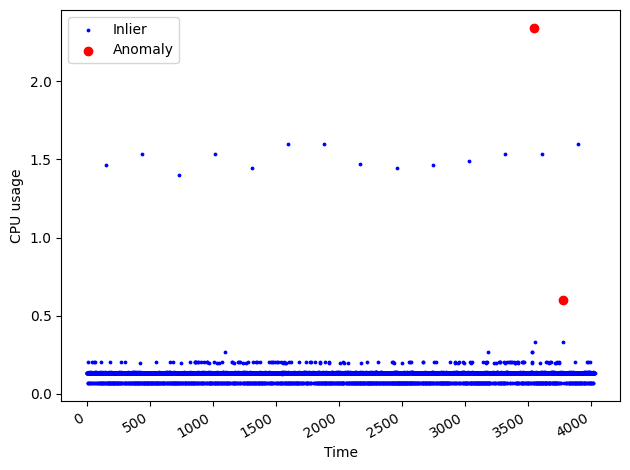

In [5]:
# визуализируем данные
anomaly_df = df.loc[df['is_anomaly'] == -1]
inlier_df = df.loc[df['is_anomaly'] == 1]

fig, ax = plt.subplots()

ax.scatter(inlier_df.index, inlier_df['value'], color='blue', s=3, label='Inlier')
ax.scatter(anomaly_df.index, anomaly_df['value'], color='red', label='Anomaly')

ax.set_xlabel('Time')
ax.set_ylabel('CPU usage')
ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

### Среднее абсолютное отклонение (MAD)

Если данные нормально распределены, то точки данных на каждом конце хвостов можно считать выбросом. <br/>
Чтобы идентифицировать их, можно использовать Z-оценку, которая представляет собой измерение стандартных отклонений от среднего значения. Если Z-оценка равна 0, значение равно среднему значению. <br/>
Обычно устанавливают пороговое значение Z-оценки 3 или 3,5, чтобы указать, является ли значение выбросом или нет.<br/>
Z-оценка рассчитывается как:
$$Z = \frac{X - \mu}{\sigma}$$

где  <br/>
$\mu$ - среднее значение выборки  <br/>
$\sigma$ - стандартное отклонение <br/>

Если Z-оценка большая, это означает, что значение далеко от среднего и ближе к одному концу хвоста распределения, что, в свою очередь, может означать, что оно является выбросом. <br/>

При пороговом значении Z = 3: если, любое значение с Z-показателем больше 3 (или меньше -3) будет помечено как выброс.<br/>



**Надежный метод Z-оценки** <br/>

Чтобы избежать влияния выбросов на Z-оценку, вместо этого используйте медиану, которая является более надежной метрикой при наличии выбросов.
Среднее абсолютное отклонение или MAD определяется как:

$$MAD = median(|x_{i} - x_{median}|)$$

MAD - медиана абсолютной разницы между значениями выборки и медианой выборки. <br/>
Надежный Z-показатель:
$$MAD = \frac{0.6745(x_{i} - x_{median})}{MAD}$$

0.6745 - это 75-й процентиль стандартного нормального распределения, к которому сходится MAD.

Надежный метод Z-балла будет лучше всего работать при двух важных предположениях: <br/>
- Данные близки к нормальному распределению
- MAD не равен 0 (происходает, когда более 50% данных имеют одинаковое значение)

Второй момент интересен, потому что если это так, то любое значение, не равное медиане, будет помечено как выброс, независимо от порога, поскольку надежный Z-показатель будет невероятно большим.

In [6]:
import numpy as np

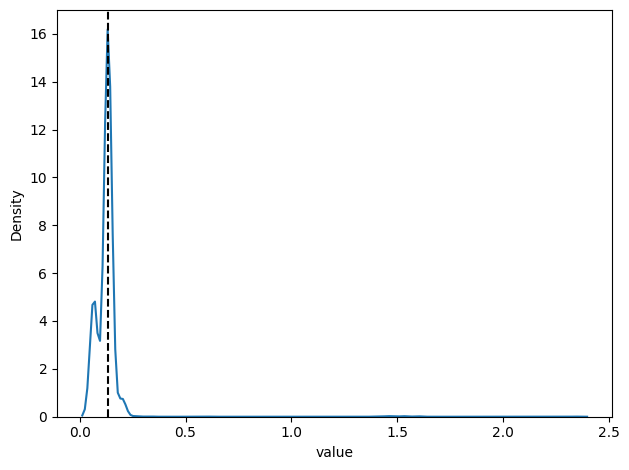

In [7]:
import seaborn as sns

sns.kdeplot(df['value']);
plt.grid(False)
plt.axvline(np.median(df['value']), 0, 1, c='black', ls='--')
plt.tight_layout()

- распределение близко к нормальному
- MAD близко к 0

In [8]:
from scipy.stats import median_abs_deviation # MAD
import numpy as np 

mad = median_abs_deviation(df['value'])
median = np.median(df['value'])

In [9]:
def compute_robust_z_score(x):
    """ вычисление надежного z-значения"""
    return .6745*(x-median)/mad

df['z-score'] = df['value'].apply(compute_robust_z_score)

In [10]:
df['baseline'] = 1

df.loc[df['z-score'] >= 3.5, 'baseline'] = -1 # Right-end tail
df.loc[df['z-score'] <= -3.5, 'baseline'] = -1 # Left-hand tail

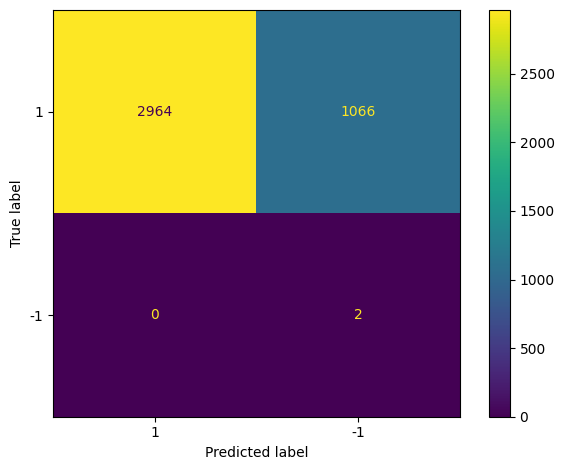

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
## is_anomaly - y_true
## baselina - y_predict
cm = confusion_matrix(df['is_anomaly'], df['baseline'], labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()

Базовый метод работает плохо, поскольку 1066 выбросов были помечены как выбросы. Опять же, это было ожидаемо, поскольку данные не соответствовали предположениям метода, а MAD был очень близок к 0. 